In [6]:
import os
from nilearn import plotting
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import nilearn.plotting as niplot
from nilearn.masking import apply_mask
from scipy.ndimage import center_of_mass
from nilearn.image import mean_img
from scipy.ndimage import label
import pandas as pd

homedir = "/Users/jan/Documents/example data/"

In [5]:
!pwd

/Users/jan/Documents/example data/BrainHack_ocular_fMRI


In [7]:
os.chdir(homedir)

In [8]:
def calculate_center_of_mass(voxel_data):
    """Compute the center of mass for a 3D voxel array."""
    # Create grid indices (voxel coordinates)
    z, y, x = np.indices(voxel_data.shape)
    
    # Total intensity (sum of all voxel values)
    total_intensity = np.sum(voxel_data)
    
    # Compute weighted average for each axis
    com_x = np.sum(x * voxel_data) / total_intensity
    com_y = np.sum(y * voxel_data) / total_intensity
    com_z = np.sum(z * voxel_data) / total_intensity
    
    return (com_x, com_y, com_z)

In [10]:
# Load fMRI (4D) and brain mask (3D)
fmri_img = nib.load("smoothed.nii")
mask_img = nib.load("BrainHack_ocular_fMRI/graymattermask_resampled.nii.gz")
eyemask_img = nib.load("BrainHack_ocular_fMRI/nau_mask_resampled.nii.gz")
fmri_data_4d = fmri_img.get_fdata()  # Must come before getting shape
n_timepoints = fmri_img.shape[3]

In [ ]:
def make_mask(fmri_img, mask_img, eyemask_img):
    fmri_data_4d = fmri_img.get_fdata()
    n_timepoints = fmri_data_4d.shape[3]
    
    left_eye_time = np.empty(n_timepoints, dtype='object')
    right_eye_time = np.empty(n_timepoints, dtype='object')
    
    left_center = np.zeros((n_timepoints, 3), dtype=float)
    right_center = np.zeros((n_timepoints, 3), dtype=float)
    
    left_center_bright = np.zeros((n_timepoints, 3), dtype=float)
    right_center_bright = np.zeros((n_timepoints, 3), dtype=float)
    
    for t in range(n_timepoints):
        
        # Extract data from one time point (e.g., the first volume)
        fmri_data_4d = fmri_img.get_fdata()
        fmri_volume = fmri_data_4d[..., t]  # Choose volume 0 (can be any time index)
        
        # Load and binarize the brain mask
        mask_data = mask_img.get_fdata().astype(bool)
        eyemask_data = eyemask_img.get_fdata().astype(bool)
        
        # Apply mask to fMRI
        brain_only = fmri_volume * mask_data
        eyes_only = fmri_volume * eyemask_data
        
        # Distinguishing the eyes
        without_gm = eyes_only - brain_only
    
        without_gm_img = nib.Nifti1Image(without_gm, affine=fmri_img.affine)
        
        # # Mask the region of interest
        # eyes_roi = np.zeros_like(eyes)
        eyes_roi = without_gm
        
       return eyes_roi

In [ ]:
def find_largest_components(eyes_roi, n_timepoints):
    for t in range(n_timepoints):
    # Flatten the ROI and keep only non-zero values
        flat_eyes_roi = eyes_roi.ravel()
        nonzero_indices = np.flatnonzero(flat_eyes_roi)
        n_nonzero = len(nonzero_indices)
        top_n = int(n_nonzero * 0.01)
        
        # print(f"Total non-zero voxels in ROI: {n_nonzero}")
        # print(f"Extracting top {top_n} voxels (top 1%)")
        
        # Get top 100 brightest voxel indices within the ROI
        flat_indices = np.argpartition(flat_eyes_roi, -top_n)[-top_n:]
        sorted_flat_indices = flat_indices[np.argsort(flat_eyes_roi[flat_indices])[::-1]]
        brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T
        
        # Create empty image to store the brightest voxels
        brightest_voxels_img = np.zeros_like(eyes_roi)
        
        # Set the intensity values at those coordinates
        for x, y, z in brightest_coords:
            brightest_voxels_img[x, y, z] = eyes_roi[x, y, z]  # You can also use eyes_roi here; same in that range
        
        # Wrap into Nifti1Image using original affine
        brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)
        # nib.save(brightest_voxels_nii, "brightest_voxels_mask.nii.gz")
    
        # Label connected components (regions of adjacent bright voxels)
        labeled, num_labels = label(brightest_voxels_img)
        
        # Find the size of each connected component (cluster)
        component_sizes = np.bincount(labeled.ravel())
        
        # Ignore background (label 0), sort the components by size and find the largest and second largest components
        sorted_indices = np.argsort(component_sizes[1:])[::-1]  # Sort in descending order (largest to smallest)
        
        # Ignore background (label 0) and find the largest component
        largest_component_label = np.argmax(component_sizes[1:]) + 1  # Skip the background (label 0)
        largest_component = labeled == largest_component_label
        
        second_largest_label = sorted_indices[1] + 1  # Add 1 to skip the background label
        # Create an image of the largest component
        largest_component_img = np.zeros_like(fmri_volume)
        largest_component_img[largest_component] = fmri_volume[largest_component]
        
        # Create the second largest component (second biggest cluster)
        second_largest_component = labeled == second_largest_label
        
        # Create an image of the second largest component
        second_largest_img = np.zeros_like(fmri_volume)
        second_largest_img[second_largest_component] = fmri_volume[second_largest_component]
        
        # Wrap into a NIfTI image
        second_largest_nii = nib.Nifti1Image(second_largest_img, affine=fmri_img.affine)
        
        # Wrap into a NIfTI image
        largest_component_nii = nib.Nifti1Image(largest_component_img, affine=fmri_img.affine)
        
        # Create an image for both clusters combined (sum of both masks)
        combined_clusters_img = np.zeros_like(fmri_volume)
        combined_clusters_img[largest_component] = fmri_volume[largest_component]
        combined_clusters_img[second_largest_component] = fmri_volume[second_largest_component]
        
        # Wrap into a NIfTI image
        combined_clusters_nii = nib.Nifti1Image(combined_clusters_img, affine=fmri_img.affine)
        
        # Find the indices (coordinates) of the voxels belonging to the largest and second largest clusters
        largest_coords = np.column_stack(np.where(largest_component))
        second_largest_coords = np.column_stack(np.where(second_largest_component))
        
        largest_coords_world = fmri_img.affine.dot(np.column_stack((largest_coords, np.ones(largest_coords.shape[0]))).T).T[:, :3]
        second_largest_coords_world = fmri_img.affine.dot(np.column_stack((second_largest_coords, np.ones(second_largest_coords.shape[0]))).T).T[:, :3]
        
        if largest_coords_world[0][0] < 0:
            left_eye_img = largest_component_nii
            right_eye_img = second_largest_nii
        else:
            left_eye_img = second_largest_nii
            right_eye_img = largest_component_nii

    return left_eye_img, right_eye_img

In [ ]:
def find_com(left_eye_img, right_eye_img, n_timepoints):
"""Finding centre of mass for each eye over time series"""
    for t in range(n_timepoints):
        left_data = left_eye_img.get_fdata()
        right_data = right_eye_img.get_fdata()
    
        com_xl, com_yl, com_zl = calculate_center_of_mass(left_data)
        com_xr, com_yr, com_zr = calculate_center_of_mass(right_data)
    
        #print(f"Center of Mass (x, y, z): ({com_x:.2f}, {com_y:.2f}, {com_z:.2f})")
        left_center[t] = [com_xl, com_yl, com_zl]
        right_center[t] = [com_xr, com_yr, com_zr]
        
        left_eye_time[t] = left_eye_img
        right_eye_time[t] = right_eye_img

    # Save the result
    # Convert each time point's image to a 3D NumPy array
    left_data = np.stack([img.get_fdata() for img in left_eye_time], axis=-1)  # shape: (X, Y, Z, T)
    right_data = np.stack([img.get_fdata() for img in right_eye_time], axis=-1)
    
    # Use the affine from the first time point
    affine = left_eye_time[0].affine
    
    # Create and save 4D NIfTI
    left_4d_img = nib.Nifti1Image(left_data, affine)
    right_4d_img = nib.Nifti1Image(right_data, affine)
    
    nib.save(left_4d_img, "left_eye_com_4d.nii.gz")
    nib.save(right_4d_img, "right_eye_com_4d.nii.gz")

    return left_center, right_center

In [81]:
def mask_time_com_bright(fmri_img, mask_img, eyemask_img):

    fmri_data_4d = fmri_img.get_fdata()
    n_timepoints = fmri_data_4d.shape[3]
    
    left_eye_time = np.empty(n_timepoints, dtype='object')
    right_eye_time = np.empty(n_timepoints, dtype='object')
    
    left_center = np.zeros((n_timepoints, 3), dtype=float)
    right_center = np.zeros((n_timepoints, 3), dtype=float)
    
    left_center_bright = np.zeros((n_timepoints, 3), dtype=float)
    right_center_bright = np.zeros((n_timepoints, 3), dtype=float)
    
    for t in range(n_timepoints):
        
        # Extract data from one time point (e.g., the first volume)
        fmri_data_4d = fmri_img.get_fdata()
        fmri_volume = fmri_data_4d[..., t]  # Choose volume 0 (can be any time index)
        
        # Load and binarize the brain mask
        mask_data = mask_img.get_fdata().astype(bool)
        eyemask_data = eyemask_img.get_fdata().astype(bool)
        
        # Apply mask to fMRI
        brain_only = fmri_volume * mask_data
        eyes_only = fmri_volume * eyemask_data
        
        # Distinguishing the eyes
        without_gm = eyes_only - brain_only
    
        without_gm_img = nib.Nifti1Image(without_gm, affine=fmri_img.affine)
        
        # # Mask the region of interest
        # eyes_roi = np.zeros_like(eyes)
        eyes_roi = without_gm
        
        # Flatten the ROI and keep only non-zero values
        flat_eyes_roi = eyes_roi.ravel()
        nonzero_indices = np.flatnonzero(flat_eyes_roi)
        n_nonzero = len(nonzero_indices)
        top_n = int(n_nonzero * 0.01)
        
        # print(f"Total non-zero voxels in ROI: {n_nonzero}")
        # print(f"Extracting top {top_n} voxels (top 1%)")
        
        # Get top 100 brightest voxel indices within the ROI
        flat_indices = np.argpartition(flat_eyes_roi, -top_n)[-top_n:]
        sorted_flat_indices = flat_indices[np.argsort(flat_eyes_roi[flat_indices])[::-1]]
        brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T
        
        # Create empty image to store the brightest voxels
        brightest_voxels_img = np.zeros_like(eyes_roi)
        
        # Set the intensity values at those coordinates
        for x, y, z in brightest_coords:
            brightest_voxels_img[x, y, z] = eyes_roi[x, y, z]  # You can also use eyes_roi here; same in that range
        
        # Wrap into Nifti1Image using original affine
        brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)
        # nib.save(brightest_voxels_nii, "brightest_voxels_mask.nii.gz")
    
        # Label connected components (regions of adjacent bright voxels)
        labeled, num_labels = label(brightest_voxels_img)
        
        # Find the size of each connected component (cluster)
        component_sizes = np.bincount(labeled.ravel())
        
        # Ignore background (label 0), sort the components by size and find the largest and second largest components
        sorted_indices = np.argsort(component_sizes[1:])[::-1]  # Sort in descending order (largest to smallest)
        
        # Ignore background (label 0) and find the largest component
        largest_component_label = np.argmax(component_sizes[1:]) + 1  # Skip the background (label 0)
        largest_component = labeled == largest_component_label
        
        second_largest_label = sorted_indices[1] + 1  # Add 1 to skip the background label
        # Create an image of the largest component
        largest_component_img = np.zeros_like(fmri_volume)
        largest_component_img[largest_component] = fmri_volume[largest_component]
        
        # Create the second largest component (second biggest cluster)
        second_largest_component = labeled == second_largest_label
        
        # Create an image of the second largest component
        second_largest_img = np.zeros_like(fmri_volume)
        second_largest_img[second_largest_component] = fmri_volume[second_largest_component]
        
        # Wrap into a NIfTI image
        second_largest_nii = nib.Nifti1Image(second_largest_img, affine=fmri_img.affine)
        
        # Wrap into a NIfTI image
        largest_component_nii = nib.Nifti1Image(largest_component_img, affine=fmri_img.affine)
        
        # Create an image for both clusters combined (sum of both masks)
        combined_clusters_img = np.zeros_like(fmri_volume)
        combined_clusters_img[largest_component] = fmri_volume[largest_component]
        combined_clusters_img[second_largest_component] = fmri_volume[second_largest_component]
        
        # Wrap into a NIfTI image
        combined_clusters_nii = nib.Nifti1Image(combined_clusters_img, affine=fmri_img.affine)
        
        # Find the indices (coordinates) of the voxels belonging to the largest and second largest clusters
        largest_coords = np.column_stack(np.where(largest_component))
        second_largest_coords = np.column_stack(np.where(second_largest_component))
        
        largest_coords_world = fmri_img.affine.dot(np.column_stack((largest_coords, np.ones(largest_coords.shape[0]))).T).T[:, :3]
        second_largest_coords_world = fmri_img.affine.dot(np.column_stack((second_largest_coords, np.ones(second_largest_coords.shape[0]))).T).T[:, :3]
        
        if largest_coords_world[0][0] < 0:
            left_eye_img = largest_component_nii
            right_eye_img = second_largest_nii
        else:
            left_eye_img = second_largest_nii
            right_eye_img = largest_component_nii
    
        left_data = left_eye_img.get_fdata()
        right_data = right_eye_img.get_fdata()
        
        # Find brightest voxel index (max intensity)
        left_max_idx = np.unravel_index(np.argmax(left_data), left_data.shape)
        right_max_idx = np.unravel_index(np.argmax(right_data), right_data.shape)
    
        com_xl, com_yl, com_zl = calculate_center_of_mass(left_data)
        com_xr, com_yr, com_zr = calculate_center_of_mass(right_data)
    
        #print(f"Center of Mass (x, y, z): ({com_x:.2f}, {com_y:.2f}, {com_z:.2f})")
        left_center[t] = [com_xl, com_yl, com_zl]
        right_center[t] = [com_xr, com_yr, com_zr]
    
        #Store voxel-space coordinates - brightness
        x_l, y_l, z_l = left_max_idx
        x_r, y_r, z_r = right_max_idx
        
        left_center_bright[t] = [x_l, y_l, z_l]
        right_center_bright[t] = [x_r, y_r, z_r]
        
        left_eye_time[t] = left_eye_img
        right_eye_time[t] = right_eye_img

    # nib.save(left_eye_time, "test_left_eye_time.nii.gz")
    # nib.save(right_eye_time, "test_right_eye_time.nii.gz")

    return left_center, right_center, left_center_bright, right_center_bright


In [82]:
left_center, right_center, left_center_bright, right_center_bright = mask_time_com_bright(fmri_img=fmri_img, mask_img=mask_img, eyemask_img=eyemask_img)

TypeError: float() argument must be a string or a real number, not 'tuple'

In [ ]:
left_center_bright

In [60]:
# Create DataFrame - CSV file - CENTRE OF MASS

df_centers = pd.DataFrame({
    'timepoint': np.arange(len(left_center)),
    'x_left_voxel': left_center[:, 0],
    'y_left_voxel': left_center[:, 1],
    'z_left_voxel': left_center[:, 2],
    'x_right_voxel': right_center[:, 0],
    'y_right_voxel': right_center[:, 1],
    'z_right_voxel': right_center[:, 2],
})

# Save to CSV
df_centers.to_csv("centre_of_mass_corrected_eye_voxels.csv", index=False)

print("Saved to centre_of_mass_corrected_eye_voxels.csv")

Saved to centre_of_mass_corrected_eye_voxels.csv


In [67]:
# Create DataFrame - CSV file - BRIGHTNESS

df_centers_brightness = pd.DataFrame({
    'timepoint': np.arange(len(left_center_bright)),
    'x_left_voxel': left_center_bright[:, 0],
    'y_left_voxel': left_center_bright[:, 1],
    'z_left_voxel': left_center_bright[:, 2],
    'x_right_voxel': right_center_bright[:, 0],
    'y_right_voxel': right_center_bright[:, 1],
    'z_right_voxel': right_center_bright[:, 2],
})

# Save to CSV
df_centers_brightness.to_csv("brightness_corrected_eye_voxels.csv", index=False)

print("Saved to brightness_corrected_eye_voxels.csv")

Saved to brightness_corrected_eye_voxels.csv


In [65]:
# CENTER OF MASS
from scipy.stats import zscore

# Select only coordinate columns
coord_cols = [
    'x_left_voxel', 'y_left_voxel', 'z_left_voxel',
    'x_right_voxel', 'y_right_voxel', 'z_right_voxel'
]

# Compute Z-scores for each coordinate
z_scores = np.abs(zscore(df_centers[coord_cols]))

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Keep only rows where ALL z-scores are below the threshold
mask = (z_scores < threshold).all(axis=1)

# Apply mask
df_cleaned = df_centers[mask].reset_index(drop=True)

df_cleaned.to_csv("df_cleaned_com.csv")

print(f"Removed {len(df_centers) - len(df_cleaned)} outliers")

Removed 7 outliers


In [63]:
cor_x = df_cleaned[['x_left_voxel', 'x_right_voxel']].corr().iloc[0, 1]
cor_y = df_cleaned[['y_left_voxel', 'y_right_voxel']].corr().iloc[0, 1]
cor_z = df_cleaned[['z_left_voxel', 'z_right_voxel']].corr().iloc[0, 1]

In [64]:
# BRIGHTNESS
from scipy.stats import zscore

# Select only coordinate columns
coord_cols = [
    'x_left_voxel', 'y_left_voxel', 'z_left_voxel',
    'x_right_voxel', 'y_right_voxel', 'z_right_voxel'
]

# Compute Z-scores for each coordinate
z_scores = np.abs(zscore(df_centers_brightness[coord_cols]))

# Define a threshold (e.g., 3 standard deviations)
threshold = 30

# Keep only rows where ALL z-scores are below the threshold
# mask = z_scores.mean(axis=1) < threshold
mask = (z_scores < threshold).all(axis=1)

# Apply mask
df_cleaned_brightness = df_centers_brightness[mask].reset_index(drop=True)

df_cleaned_brightness.to_csv("df_cleaned_brightness.csv", index=False)

print(f"Removed {len(df_centers_brightness) - len(df_cleaned_brightness)} outliers")

Removed 128 outliers


In [53]:
cor_x_brightness = df_cleaned_brightness[['x_left_voxel', 'x_right_voxel']].corr().iloc[0, 1]
cor_y_brightness = df_cleaned_brightness[['y_left_voxel', 'y_right_voxel']].corr().iloc[0, 1]
cor_z_brightness = df_cleaned_brightness[['z_left_voxel', 'z_right_voxel']].corr().iloc[0, 1]

In [44]:
128/768

0.16666666666666666

In [34]:
df = pd.read_csv("brightness_corrected_eye_voxels.csv")

In [145]:
df = pd.read_csv("centre_of_mass_corrected_eye_voxels.csv")

In [36]:
import seaborn as sns

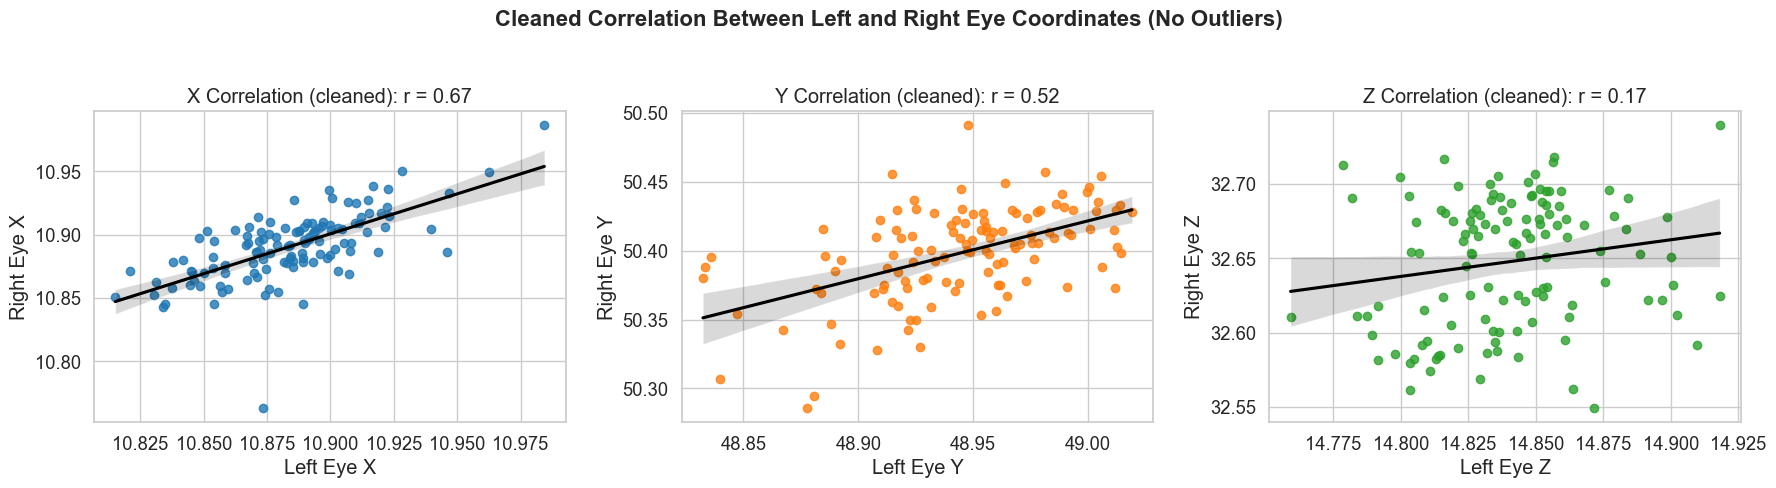

In [54]:
# CENTER OF MASS 
sns.set(style="whitegrid", font_scale=1.2)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(data=df_cleaned, x='x_left_voxel', y='x_right_voxel', ax=axs[0], color='#1f77b4', line_kws={'color': 'black'})
axs[0].set_title(f"X Correlation (cleaned): r = {cor_x:.2f}")
axs[0].set_xlabel("Left Eye X")
axs[0].set_ylabel("Right Eye X")

sns.regplot(data=df_cleaned, x='y_left_voxel', y='y_right_voxel', ax=axs[1], color='#ff7f0e', line_kws={'color': 'black'})
axs[1].set_title(f"Y Correlation (cleaned): r = {cor_y:.2f}")
axs[1].set_xlabel("Left Eye Y")
axs[1].set_ylabel("Right Eye Y")

sns.regplot(data=df_cleaned, x='z_left_voxel', y='z_right_voxel', ax=axs[2], color='#2ca02c', line_kws={'color': 'black'})
axs[2].set_title(f"Z Correlation (cleaned): r = {cor_z:.2f}")
axs[2].set_xlabel("Left Eye Z")
axs[2].set_ylabel("Right Eye Z")

plt.savefig("bright_eye_voxel_correlation_outliers_removed_plot.png")

plt.suptitle("Cleaned Correlation Between Left and Right Eye Coordinates (No Outliers)", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

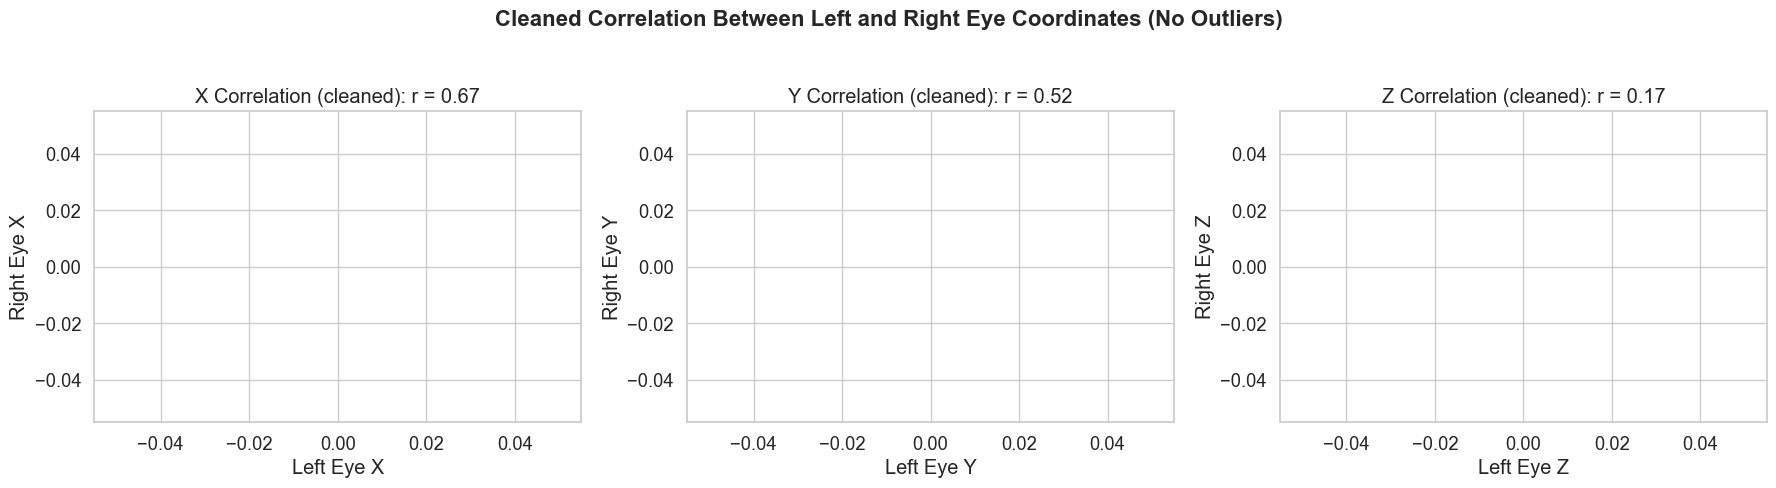

In [50]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(data=df_cleaned_brightness, x='x_left_voxel', y='x_right_voxel', ax=axs[0], color='#1f77b4', line_kws={'color': 'black'})
axs[0].set_title(f"X Correlation (cleaned): r = {cor_x:.2f}")
axs[0].set_xlabel("Left Eye X")
axs[0].set_ylabel("Right Eye X")

sns.regplot(data=df_cleaned_brightness, x='y_left_voxel', y='y_right_voxel', ax=axs[1], color='#ff7f0e', line_kws={'color': 'black'})
axs[1].set_title(f"Y Correlation (cleaned): r = {cor_y:.2f}")
axs[1].set_xlabel("Left Eye Y")
axs[1].set_ylabel("Right Eye Y")

sns.regplot(data=df_cleaned_brightness, x='z_left_voxel', y='z_right_voxel', ax=axs[2], color='#2ca02c', line_kws={'color': 'black'})
axs[2].set_title(f"Z Correlation (cleaned): r = {cor_z:.2f}")
axs[2].set_xlabel("Left Eye Z")
axs[2].set_ylabel("Right Eye Z")

plt.savefig("bright_eye_voxel_correlation_outliers_removed_plot.png")

plt.suptitle("Cleaned Correlation Between Left and Right Eye Coordinates (No Outliers)", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [24]:
# Save the result
# Convert each time point's image to a 3D NumPy array
left_data = np.stack([img.get_fdata() for img in left_eye_time], axis=-1)  # shape: (X, Y, Z, T)
right_data = np.stack([img.get_fdata() for img in right_eye_time], axis=-1)

# Use the affine from the first time point
affine = left_eye_time[0].affine

# Create and save 4D NIfTI
left_4d_img = nib.Nifti1Image(left_data, affine)
right_4d_img = nib.Nifti1Image(right_data, affine)

nib.save(left_4d_img, "left_eye_time.nii.gz")
nib.save(right_4d_img, "right_eye_time.nii.gz")

In [26]:
# Save the results - Python
np.save("left_eye_centers.npy", left_center)
np.save("right_eye_centers.npy", right_center)

In [36]:
# Create DataFrame - CSV file
df_centers = pd.DataFrame({
    'timepoint': np.arange(len(left_center)),
    'x_left_voxel': left_center[:, 0],
    'y_left_voxel': left_center[:, 1],
    'z_left_voxel': left_center[:, 2],
    'x_right_voxel': right_center[:, 0],
    'y_right_voxel': right_center[:, 1],
    'z_right_voxel': right_center[:, 2],
})

# Save to CSV
df_centers.to_csv("brightest_eye_voxels.csv", index=False)

print("Saved to brightest_eye_voxels.csv")

Saved to brightest_eye_voxels.csv


In [ ]:
# MULTI VOXEL PATTERN ANALYSIS
# compare brightness of voxels in all time points
# run a correlation between subsequent slices

In [80]:
# Difference between time points for each coordinate
left_deltas = np.diff(left_center, axis=0)     # shape: (T-1, 3)
right_deltas = np.diff(right_center, axis=0)   # shape: (T-1, 3)

# You can also compute the overall distance moved at each step
left_movement = np.linalg.norm(left_deltas, axis=1)
right_movement = np.linalg.norm(right_deltas, axis=1)

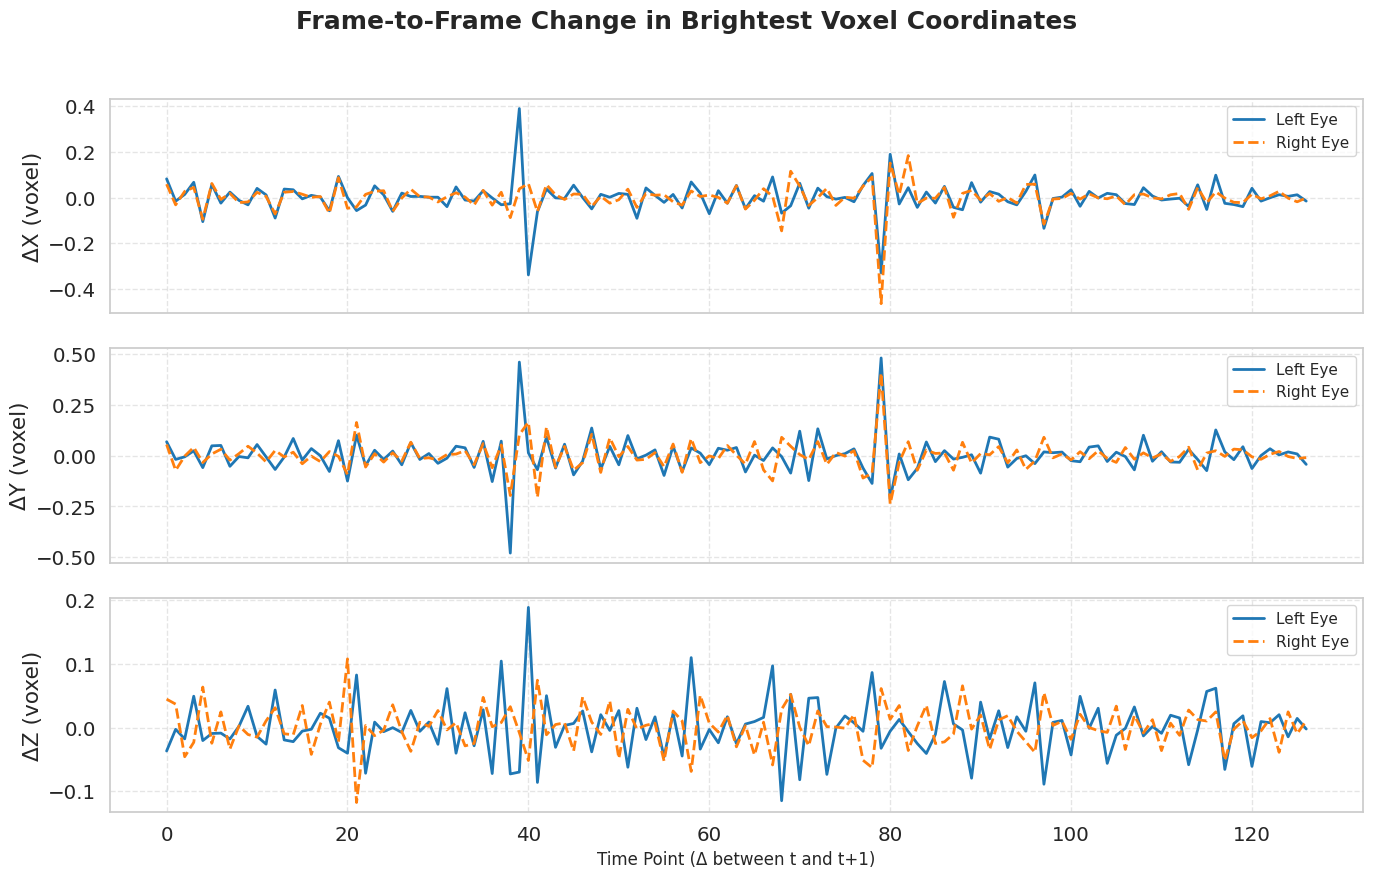

In [82]:
# Optional: set your own color palette
sns.set(style="whitegrid", context="notebook", font_scale=1.3)

# Axis labels
coords = ['X', 'Y', 'Z']
colors = {'Left': '#1f77b4', 'Right': '#ff7f0e'}
fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

for i, coord in enumerate(coords):
    axs[i].plot(left_deltas[:, i], label='Left Eye', color=colors['Left'], linewidth=2)
    axs[i].plot(right_deltas[:, i], label='Right Eye', color=colors['Right'], linewidth=2, linestyle='--')
    axs[i].set_ylabel(f'Δ{coord} (voxel)')
    axs[i].legend(loc='upper right', fontsize=11)
    axs[i].grid(True, linestyle='--', alpha=0.5)

axs[2].set_xlabel('Time Point (Δ between t and t+1)', fontsize=12)
fig.suptitle("Frame-to-Frame Change in Brightest Voxel Coordinates", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig.savefig("ChangeBetweenVoxels.png", dpi=300)